In [3]:
import torch
import rasterio
import numpy as np

In [7]:
from pathlib import Path

DATASET_DIR = Path("datasets")
BUILDING_DATASET_DIR = DATASET_DIR / "sentinel" / "bologna"
SENTINEL_DATASET_DIR = DATASET_DIR / "sentinel" / "bologna"

In [8]:
from matplotlib import pyplot as plt

def normalize(img):
    masked_data = np.ma.masked_equal(img, 0)
    lq, uq = np.quantile(masked_data.compressed(), (0.01, 0.99))
    image_norm = np.clip(img, a_min=lq, a_max=uq)
    image_norm = (image_norm - lq) / (uq - lq)
    return image_norm

def vis(img, quant_norm=True):
    if quant_norm:
        data = normalize(img)
    else:
        data = img
    if data.ndim == 2:
        plt.imshow(data, cmap="gray")
    elif data.ndim == 3:
        plt.imshow(data)

    

(1548, 1665, 4)


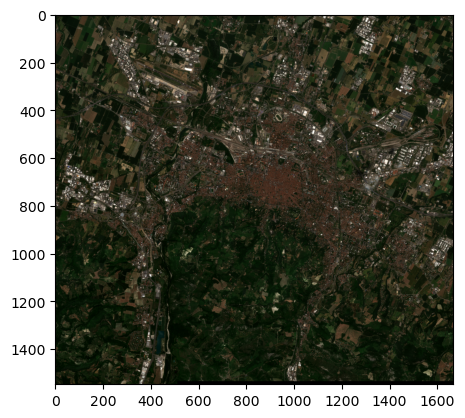

In [9]:
with rasterio.open(SENTINEL_DATASET_DIR / "R.tiff") as f:
    r_data = np.transpose(f.read(), (1,2,0)).squeeze()
with rasterio.open(SENTINEL_DATASET_DIR / "G.tiff") as f:
    g_data = np.transpose(f.read(), (1,2,0)).squeeze()    
with rasterio.open(SENTINEL_DATASET_DIR / "B.tiff") as f:
    b_data = np.transpose(f.read(), (1,2,0)).squeeze()
with rasterio.open(SENTINEL_DATASET_DIR / "IR.tiff") as f:
    ir_data = np.transpose(f.read(), (1,2,0)).squeeze()

with rasterio.open(BUILDING_DATASET_DIR / "footprint.tiff") as f:
    building_data = np.transpose(f.read(), (1,2,0)).squeeze()


all_bands = np.stack([r_data, g_data, b_data, ir_data], axis=-1)
print(all_bands.shape)
all_bands = normalize(all_bands)
vis(all_bands[:,:,:3], quant_norm=False)

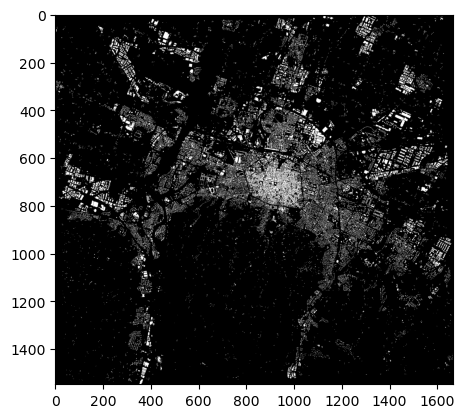

In [10]:
vis(building_data, quant_norm=False)

In [11]:
# Cloud classification

from sklearn.cluster import KMeans
stacked_data = np.stack([ir_data, r_data, g_data, b_data], axis=-1).reshape(-1, 4)
kmeans = KMeans(n_clusters=2, random_state=0).fit(stacked_data)
labels = kmeans.labels_.reshape(ir_data.shape)

cloud_label = kmeans.cluster_centers_[:, 0].argmax()
cloud_mask = labels == cloud_label

print(cloud_mask.shape)


# Add cloud mask to input_output_tensor
preprocess_data = np.dstack([all_bands, building_data, cloud_mask.astype(np.float32)])
preprocess_tensor = torch.from_numpy(preprocess_data)

/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(1548, 1665)


In [12]:
np.count_nonzero(preprocess_data[:,:,5] == 0)

13836

In [13]:
preprocess_tensor.size()

torch.Size([1548, 1665, 6])

torch.Size([48, 52, 32, 32, 6])
torch.Size([2496, 32, 32, 6])


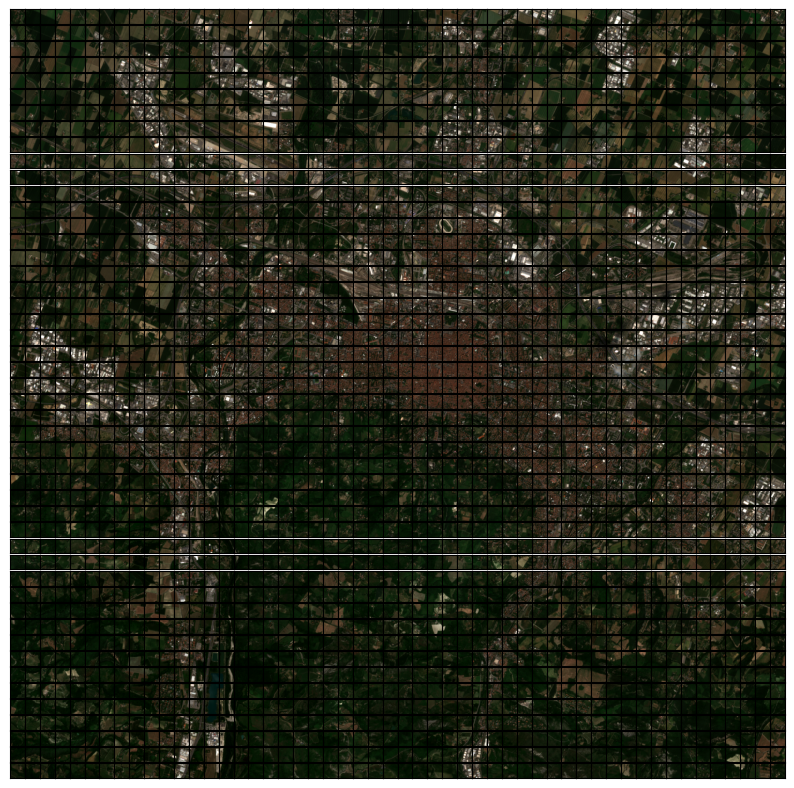

In [14]:
image_height, image_width = preprocess_tensor.size()[:2]

patch_size = 32

patches_grid = preprocess_tensor.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size).permute(0,1,3,4,2)
patches_num_x, patches_num_y = patches_grid.size()[:2]
print(patches_grid.size())
patches = patches_grid.flatten(start_dim=0, end_dim=1)
print(patches.size())

plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the patches in a grid
for x in range(patches_num_x):
    for y in range(patches_num_y):
        ax = plt.subplot(patches_num_x, patches_num_y, x*patches_num_y + y + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.axis("off")
        
        patch_rgb = patches_grid[x, y, :, :, :3]
        plt.imshow(patch_rgb)
        # plt.imshow(patches_grid[x, y, :, :, 4], cmap="gray")

torch.Size([1536, 1664, 6])


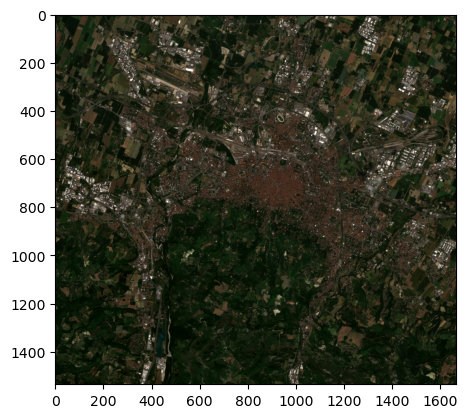

In [15]:
# Test reconstruction
patches_grid_recon = patches.view(patches_num_x, patches_num_y, patch_size, patch_size, preprocess_tensor.size(2))
patches_grid_recon = patches_grid_recon.permute(0, 2, 1, 3, 4).contiguous()
patches_grid_recon = patches_grid_recon.view(patches_num_x * patch_size, patches_num_y * patch_size, preprocess_tensor.size(2))

print(patches_grid_recon.size())
vis(patches_grid_recon[:,:,:3], quant_norm=False)

In [16]:
def is_cloud_present(img):
    if np.count_nonzero(img[:,:,5] == False) > 0:
        return True
    return False

valid_patches = []
for i in range(len(patches)):
    if not is_cloud_present(patches[i]):
        valid_patches.append(i)
print(f"{len(valid_patches)}/{len(patches)} patches are valid")

2496/2496 patches are valid


In [17]:
from torch.utils.data import TensorDataset
input_tensor = patches[valid_patches, :, :, :3].permute(0,3,1,2) # change dims to (N, C, H, W)
output_tensor = patches[valid_patches, :, :, 4]
dataset = TensorDataset(input_tensor, output_tensor)

In [22]:
import torchvision.transforms as T
from torchvision.transforms import functional as TF

#Data augmentation
augmentations = {
    "rotation": T.RandomRotation(30),
    "reflection": T.RandomHorizontalFlip(1),
    "zoom": T.RandomResizedCrop(size=patch_size, scale=(0.6, 1.0)),
    #"modulated_noise": lambda img: img + torch.randn_like(img) * 0.1,
    "affine": T.RandomAffine((50, 60))
}

compound_augmentations = {
    "rotate_reflect": T.Compose([augmentations["rotation"], augmentations["reflection"]]),
    "rotate_zoom": T.Compose([augmentations["rotation"], augmentations["zoom"]]),
    #"rotate_noise": T.Compose([augmentations["rotation"], augmentations["modulated_noise"]]),
    "rotate_affine": T.Compose([augmentations["rotation"], augmentations["affine"]]),
    "reflect_zoom": T.Compose([augmentations["reflection"], augmentations["zoom"]]),
    #"reflect_noise": T.Compose([augmentations["reflection"], augmentations["modulated_noise"]]),
    "reflect_affine": T.Compose([augmentations["reflection"], augmentations["affine"]]),
    "zoom_affine": T.Compose([augmentations["zoom"], augmentations["affine"]]),
    #"affine_noise": T.Compose([augmentations["affine"], augmentations["modulated_noise"]]),
    "rotate_reflect_affine": T.Compose([augmentations["rotation"], augmentations["reflection"], augmentations["affine"]]),
    "all": T.Compose([augmentations["rotation"], augmentations["reflection"], augmentations["zoom"], augmentations["affine"]])
}

def apply_transform(data, transform):
    x, y = data
    x = TF.to_pil_image(x)
    x = transform(x)
    x = TF.to_tensor(x)
    return x, y

In [30]:
augmented_datasets = {}
for name, transform in augmentations.items():
    augmented_datasets[name] = [(apply_transform(data, transform)) for data in dataset]

In [32]:
for name, transform in compound_augmentations.items():
    augmented_datasets[name] = [(apply_transform(data, transform)) for data in dataset]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Augmentation: rotation


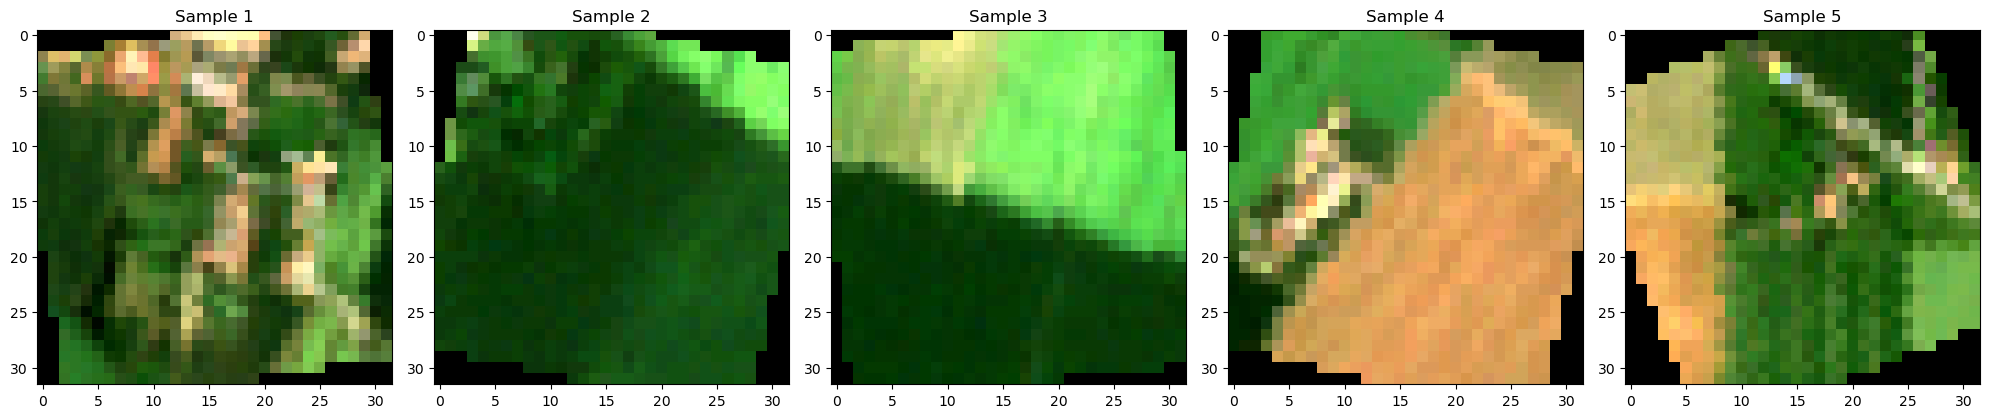

Augmentation: reflection


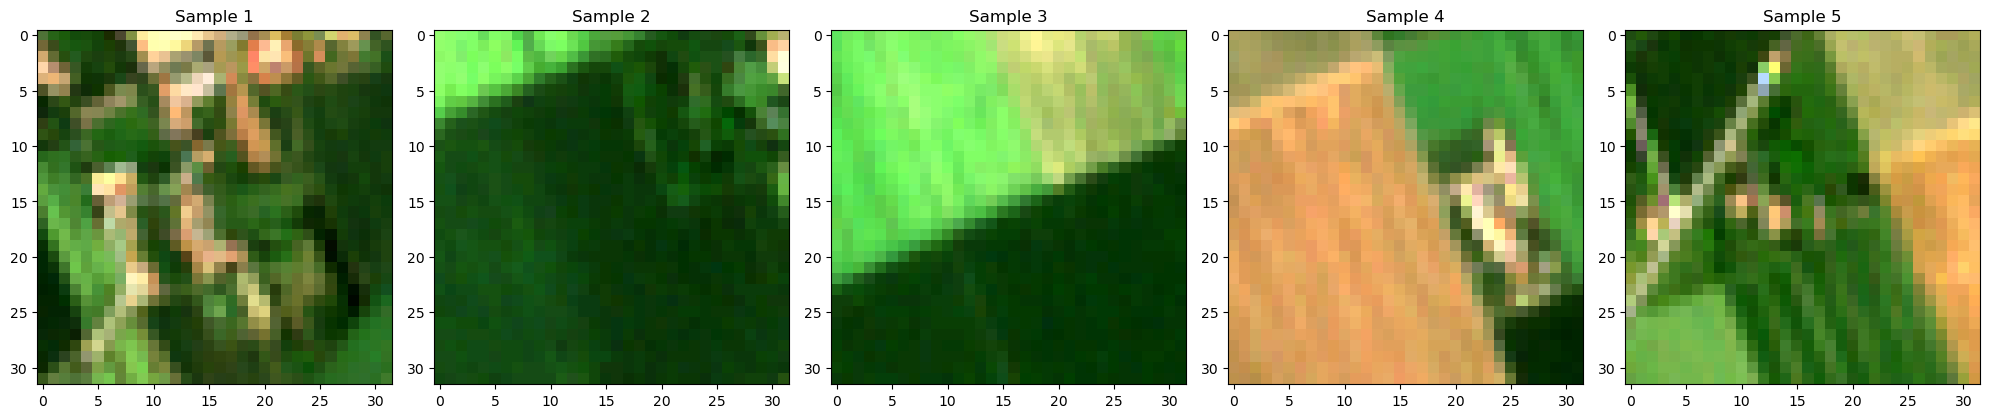

Augmentation: zoom


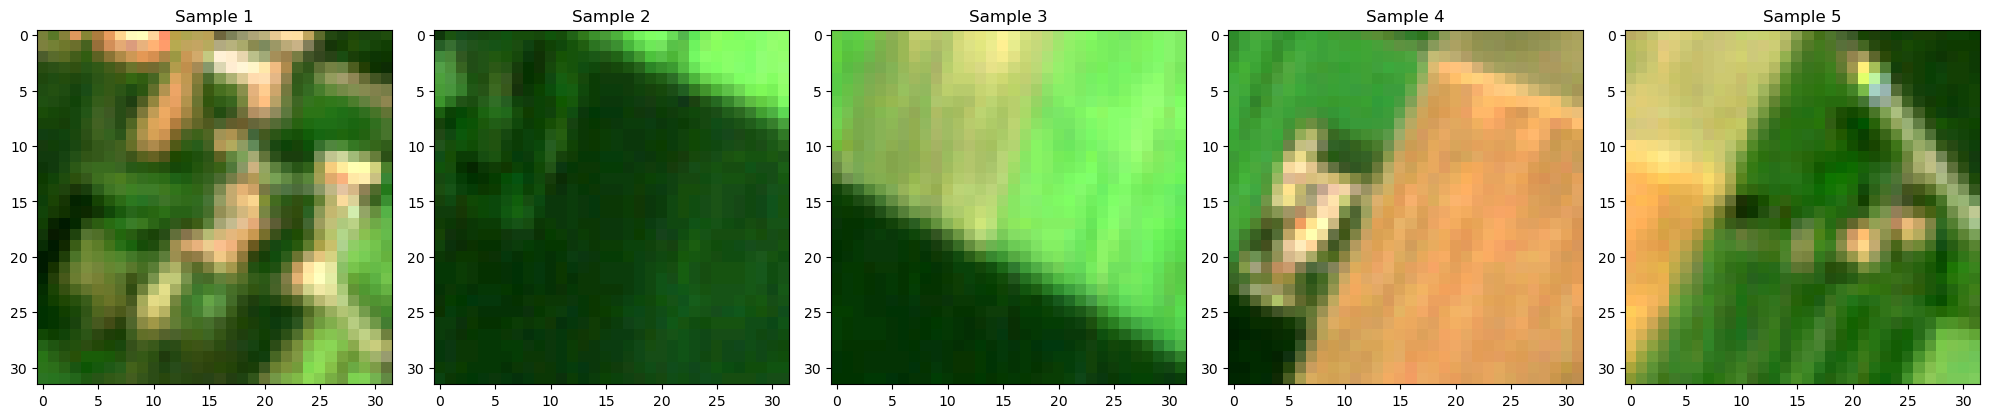

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Augmentation: affine


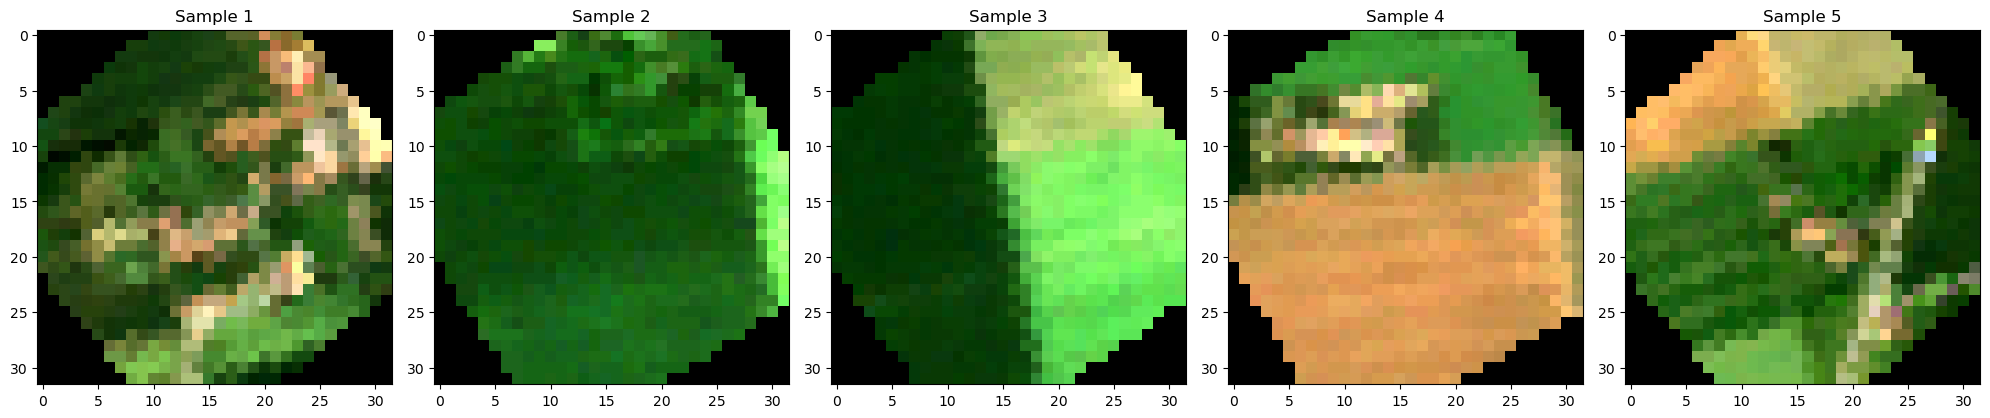

Augmentation: rotate_reflect


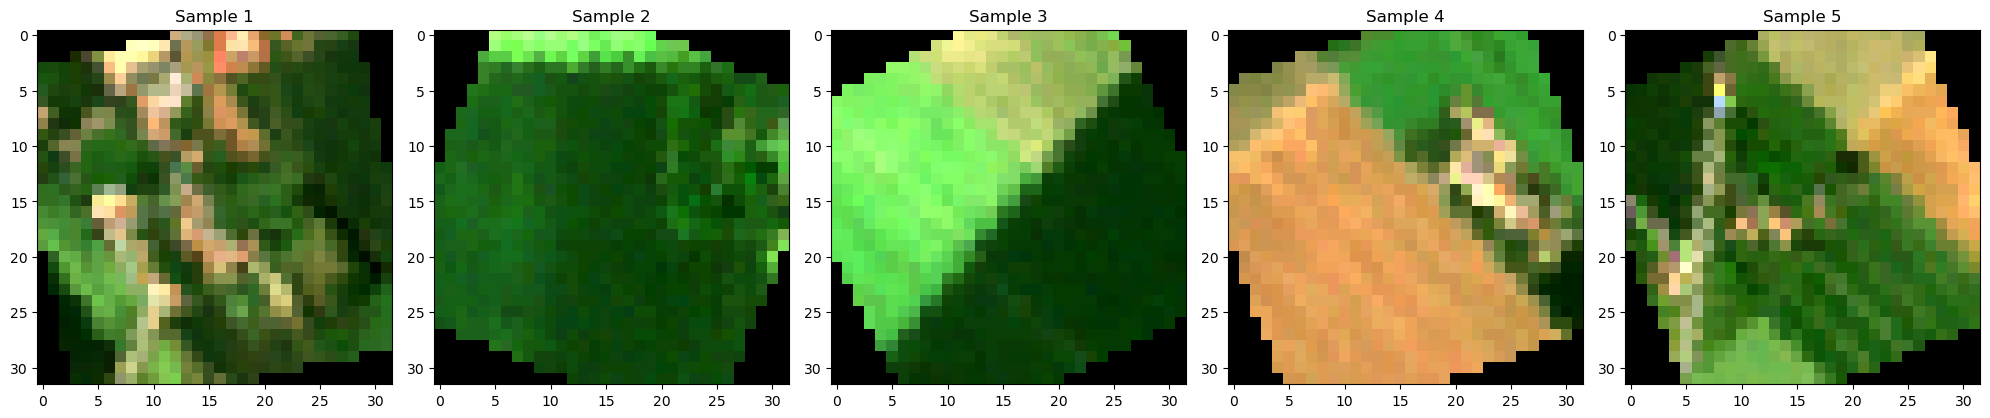

Augmentation: rotate_zoom


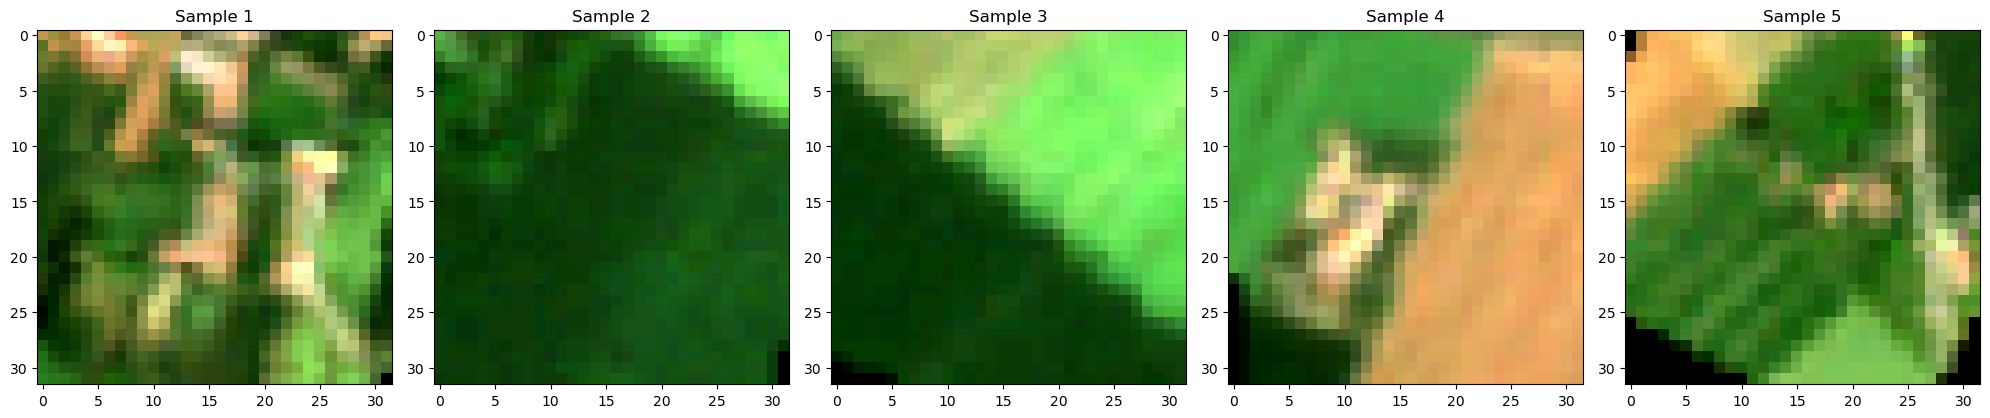

Augmentation: rotate_affine


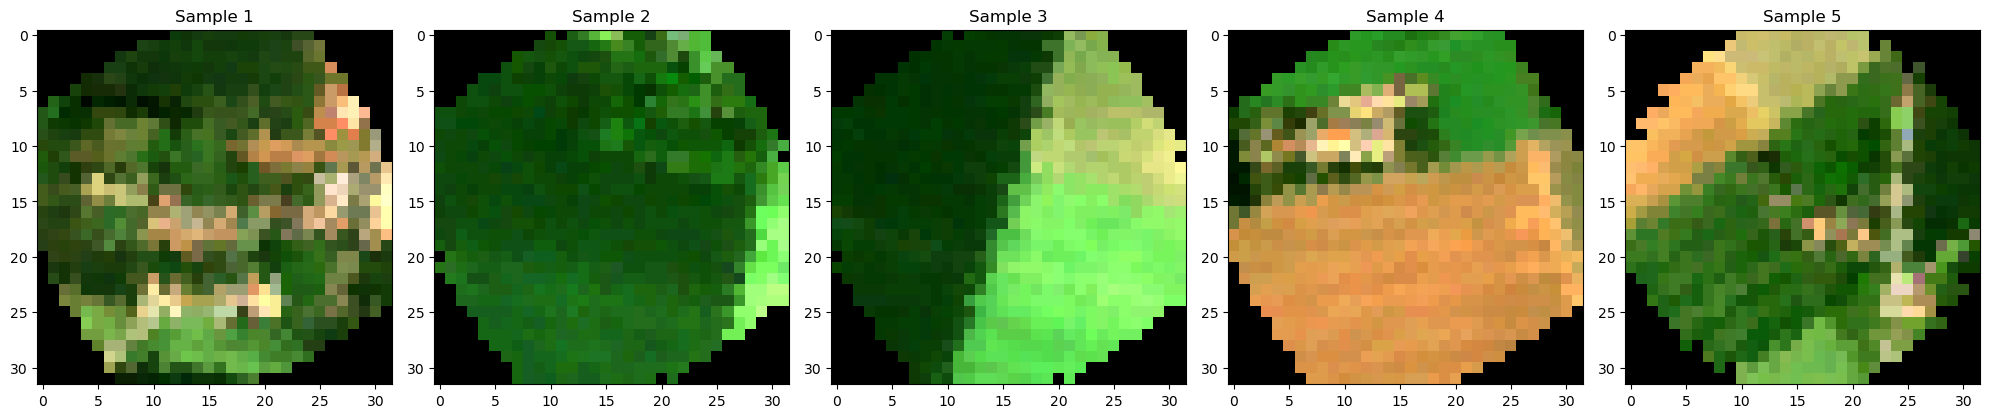

Augmentation: reflect_zoom


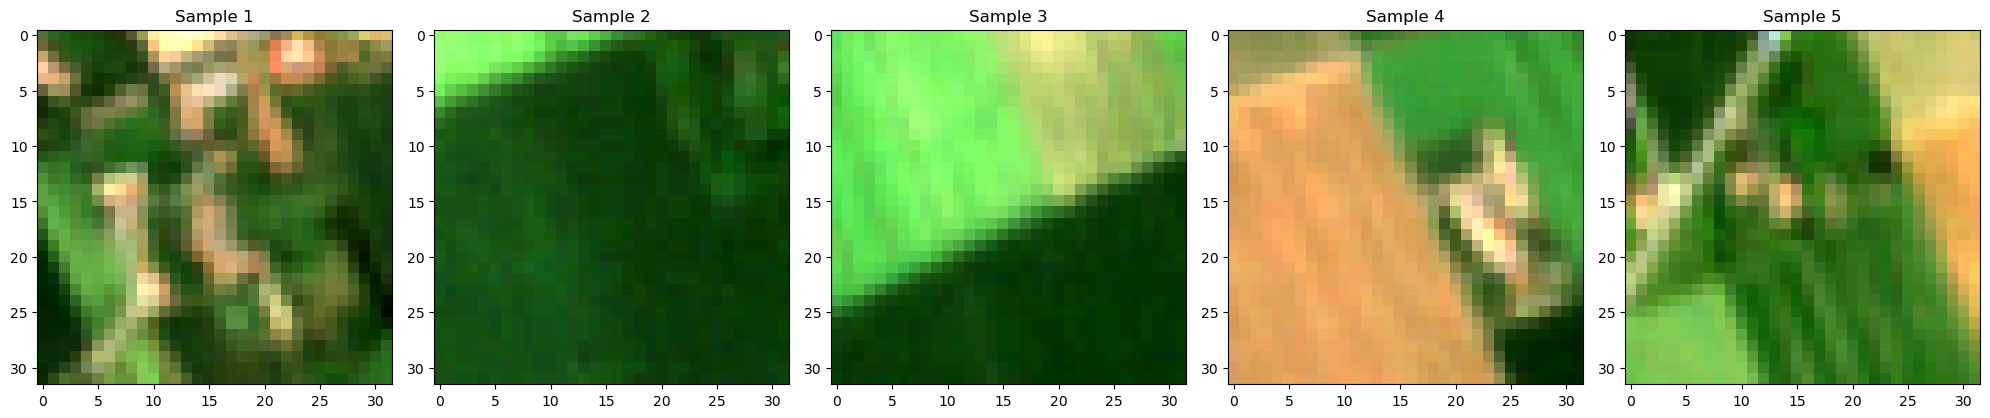

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Augmentation: reflect_affine


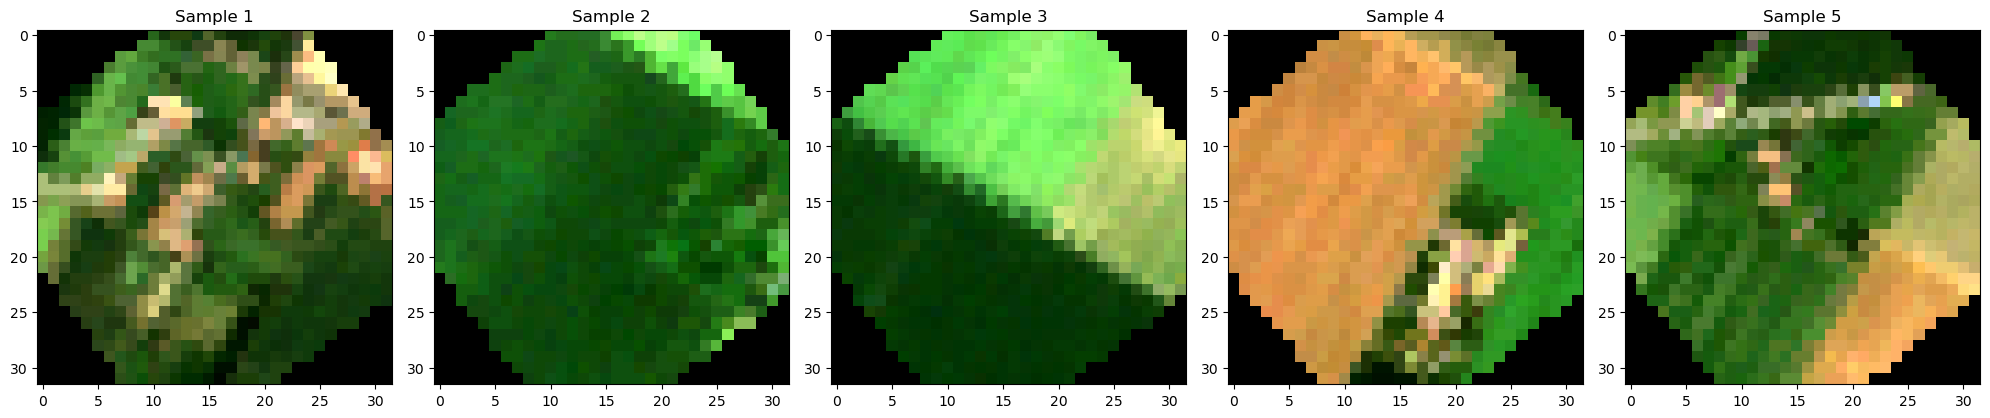

Augmentation: zoom_affine


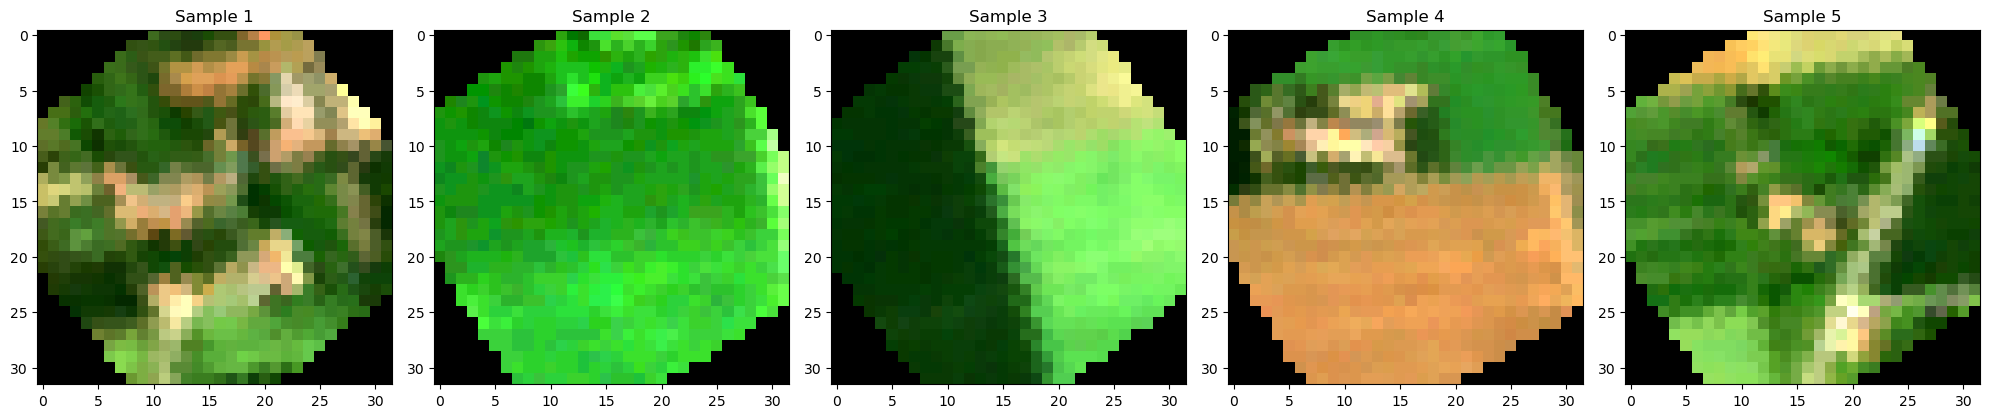

Augmentation: rotate_reflect_affine


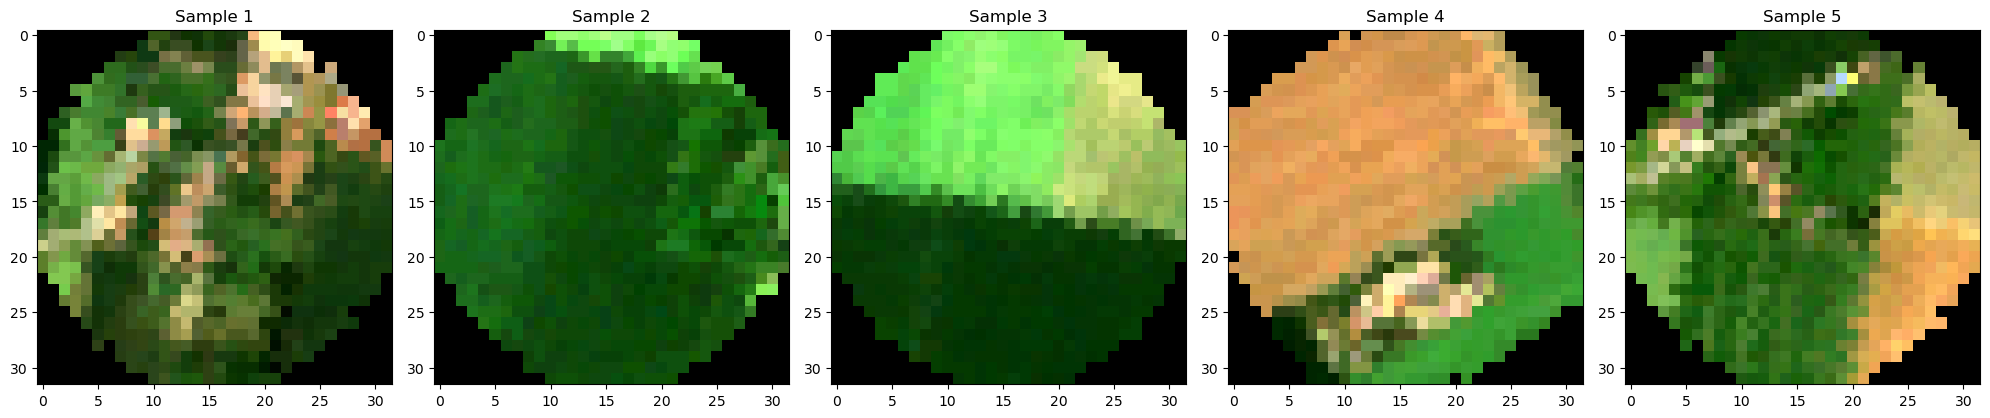

Augmentation: all


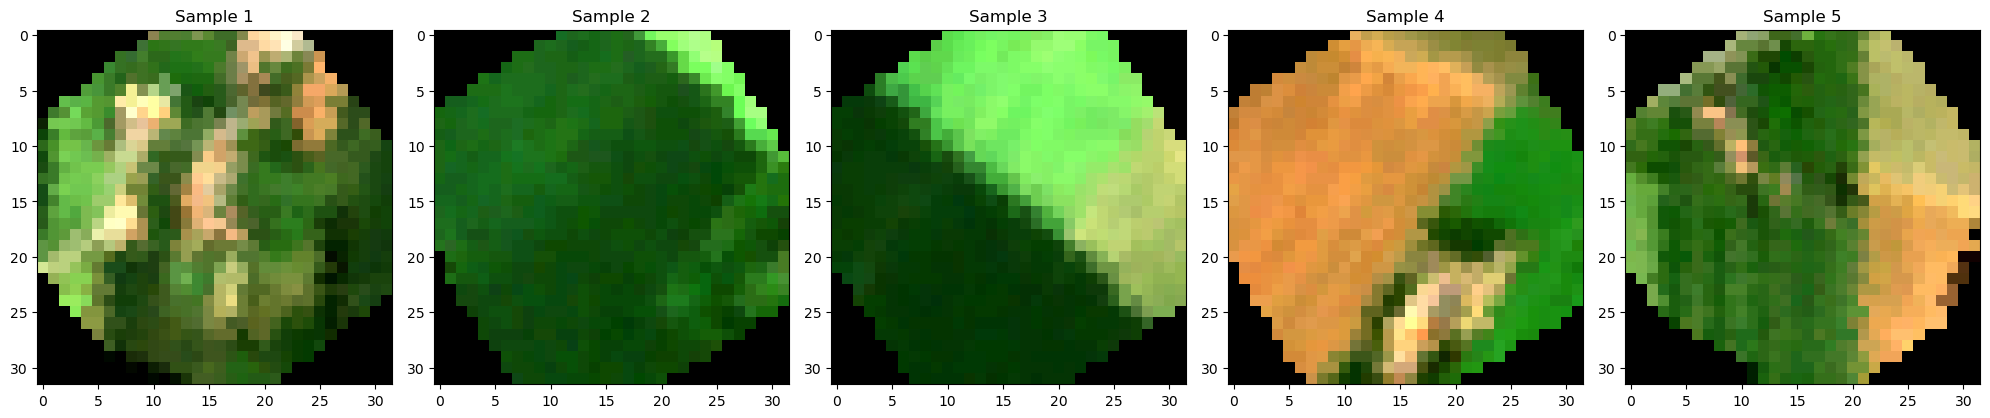

In [35]:
for name, samples in augmented_datasets.items():
    print(f"Augmentation: {name}")
    plt.figure(figsize=(20, 10))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        vis(samples[i][0].numpy().transpose(1, 2, 0))
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

In [ ]:
generator = torch.Generator().manual_seed(42)
train, test, val = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2], generator=generator)
len(train), len(test), len(val)

In [ ]:
torch.save(train, 'torch/train.pt')
torch.save(val, 'torch/val.pt')
torch.save(test, 'torch/test.pt')

In [ ]:
image = TensorDataset(torch.from_numpy(np.expand_dims(all_bands[:,:,:3], 0)).permute(0,3,1,2), torch.from_numpy(np.expand_dims(building_data, 0)))
torch.save(image, 'torch/bologna.pt')